#Кластеризація в Аналізі Персоналій Клієнтів
Огляд даних, робота з викидами проведено в іншому ноутбуці.
Тут будуть використані колонки з базового набору даних + час на платформі (замість Dt_Customer) та вік клієнта (замість 	Year_Birth).
В даному ноутбуці з підготовки даних буде проведено кодування категоріальних колонок та масштабування даних.

Основна задача це провести дослідження з підбору методу кластерізації даного набору даних та інтерпритація портретів клієнтів з застосуванням методів пониження розмірності.


#Import

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import seaborn as sns


from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn_extra.cluster import KMedoids


from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Functions

##Data

In [ ]:
path_to_1 = '/content/drive/MyDrive/Python/ML/DATA/marketing_campaign_1.csv'

In [ ]:
path_to = '/content/drive/MyDrive/Python/ML/DATA/df_clean.csv'

In [ ]:
df_1 = pd.read_csv(path_to_1)
df_1.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [ ]:
#зчитування даних
df = pd.read_csv(path_to)

In [ ]:
#огляд даних
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2131 entries, 0 to 2130
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2131 non-null   int64  
 1   Year_Birth           2131 non-null   int64  
 2   Education            2131 non-null   object 
 3   Marital_Status       2131 non-null   object 
 4   Income               2131 non-null   float64
 5   Kidhome              2131 non-null   int64  
 6   Teenhome             2131 non-null   int64  
 7   Dt_Customer          2131 non-null   object 
 8   Recency              2131 non-null   int64  
 9   MntWines             2131 non-null   int64  
 10  MntFruits            2131 non-null   int64  
 11  MntMeatProducts      2131 non-null   int64  
 12  MntFishProducts      2131 non-null   int64  
 13  MntSweetProducts     2131 non-null   int64  
 14  MntGoldProds         2131 non-null   int64  
 15  NumDealsPurchases    2131 non-null   i

In [ ]:
df.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Income_not_filled,Minor,Type_minor,Mnt,Mnt_count,Mnt_count_list,Mnt_type,Accept_count,Num_purchases,ASP
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,False,0,немає неповнолітніх,1617,6,"[1, 1, 1, 1, 1, 1]","1,1,1,1,1,1",1,20,80.850000
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,False,2,"діти(1), підлітки(1)",27,6,"[1, 1, 1, 1, 1, 1]","1,1,1,1,1,1",0,4,6.750000
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,False,0,немає неповнолітніх,776,6,"[1, 1, 1, 1, 1, 1]","1,1,1,1,1,1",0,26,29.846154
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,False,1,"діти(1), підлітки(0)",53,6,"[1, 1, 1, 1, 1, 1]","1,1,1,1,1,1",0,8,6.625000
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,False,1,"діти(1), підлітки(0)",422,6,"[1, 1, 1, 1, 1, 1]","1,1,1,1,1,1",0,16,26.375000


#Pre-processing



**Education**

In [ ]:
#Застосую до даних про освіту LableEncoding
Education_dict = {'Basic': 1,
                  'Graduation': 2,
                  '2n Cycle': 3,
                  'Master': 4,
                  'PhD': 5}

df['Education_Order'] = df.Education.map(Education_dict)

До колонок 'Marital_Status', 'Type_minor', 'Mnt_count_list', 'Mnt_type' застосуємо OneHotEncoder.

In [ ]:
col_enc = ['Marital_Status', 'Type_minor', 'Mnt_count_list', 'Mnt_type']

for col in col_enc:
    df = pd.get_dummies(df, columns= [col], drop_first=False)

#KMeans без масштабування

В даному розділі буде:
1. Побудова кластеризацію з KMeans на 3 кластери.
2. Обчислення метрики силуету для цієї кластеризації.

Підготовка даних для KMeans

In [ ]:
#Виводимо колонки щоб обрати в датафрейм на кластеризацію всі, окрім 'ID' та 'Dt_Customer' (оскільки KMeans не сприймає дані не в числовому форматі), без колонок 'Z_CostContact', 'Z_Revenue' (які при порередньому аналізі показали однакові дані для всіх рядків)
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome',
       'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Days_lifetime', 'Age_client',
       'Income_not_filled', 'Minor', 'Mnt', 'Mnt_count', 'Accept_count',
       'Num_purchases', 'ASP', 'Education_Order', 'Marital_Status_Divorced',
       'Marital_Status_Else', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Type_minor_діти(0), підлітки(1)',
       'Type_minor_діти(0), підлітки(2)', 'Type_minor_діти(1), підлітки(0)',
       'Type_minor_діти(1), підлітки(1)', 'Type_minor_діти(1), підлітки(2)',
       'Type_minor_діти(2), підлітк

In [ ]:
df_1.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [ ]:
columns_for_task = [ 'Education_Order', 'Marital_Status_Divorced',
       'Marital_Status_Else', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response',
       'Days_lifetime', 'Age_client', 'Mnt', 'ASP']
X_kmean=df[columns_for_task]

In [ ]:
# Визначаємо модель за заданими параметрами
kmeans = KMeans(n_clusters=3, n_init='auto')
#тренуємо модель
kmeans.fit(X_kmean)
labels = kmeans.predict(X_kmean)

In [ ]:
#Рахуємо метрику силуету для цієї кластеризації
centroids = kmeans.cluster_centers_
s = metrics.silhouette_score(X_kmean, labels, metric='euclidean')
print(f'Silhouette Coefficient for the data Dataset Clusters: {s:.2f}')

Silhouette Coefficient for the data Dataset Clusters: 0.54


#Візуалізація Kmeans без масштабування

In [ ]:
# Візуалізація
fig = px.scatter_3d(X_kmean, x= 'Age_client', y='MntWines', z='Income',
              color= labels)
fig.show()

#Kmeans з масштабуванням

В даному розділі масштабуємо дані  і будуємо знову кластеризацію KMeans на 3 кластери, обчислюємо метрику силуету.

In [ ]:
# Масштабування даних
scaler = StandardScaler()
scaler.fit(X_kmean)
X_kmean_sc = scaler.transform(X_kmean)

# Перетворення назад у DataFrame
X_kmean_dc = pd.DataFrame(X_kmean_sc, columns=X_kmean.columns)

In [ ]:
# Визначаємо модель за заданими параметрами
kmeans_sc = KMeans(n_clusters=3, n_init='auto')
#тренуємо модель
kmeans_sc.fit(X_kmean_dc)
labels_sc = kmeans_sc.predict(X_kmean_dc)

In [ ]:
#Рахуємо метрику силуету для цієї кластеризації
centroids = kmeans_sc.cluster_centers_
s = metrics.silhouette_score(X_kmean_dc, labels_sc, metric='euclidean')
print(f'Silhouette Coefficient for the data Dataset Clusters: {s:.2f}')

Silhouette Coefficient for the data Dataset Clusters: 0.11


In [ ]:
# Візуалізація

fig = px.scatter_3d(X_kmean_dc, x= 'Age_client', y='MntWines', z='Income',
              color= labels_sc)
fig.show()

**Висновки:**
1. При кластеризації без масштабування одним з основних критеріїв був - дохід клієнта і метрика силуета становила - 0.54
2. при кластеризації з масштабуванням якість знизилась до 0.11
3. У нас дані без викидів.

#Elbow method

В даному розділі буде:
1. Виконано пошук  оптимальної кількості кластерів за допомогою Elbow method;
2. Тренування  KMeans з тою кількістю кластерів, яку Elbow method показав як оптимальну;
3. Обчислення метрики силуету, візуалізуція кластерів.

**Немасштабовані дані**

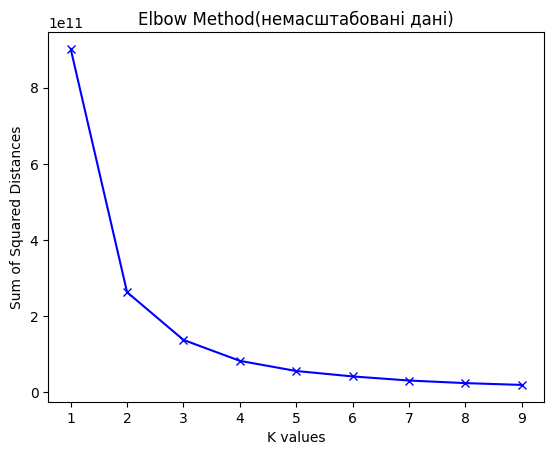

In [ ]:
K = range(1,10)
sum_of_squared_distances = []

for k in K:
    model = KMeans(n_clusters=k, n_init='auto').fit(X_kmean)
    sum_of_squared_distances.append(model.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('K values')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method(немасштабовані дані)')
plt.show()

**Масштабовані дані**

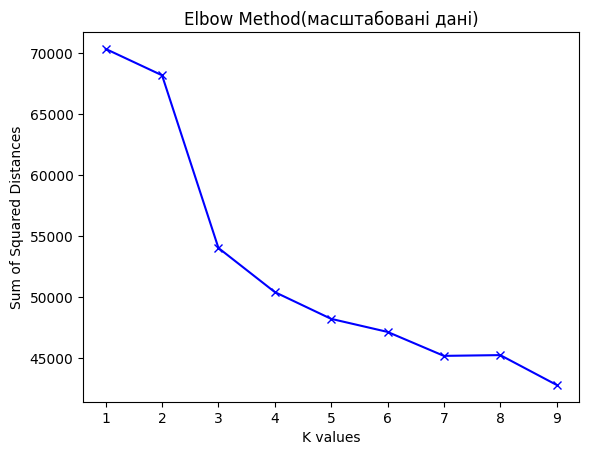

In [ ]:
K = range(1,10)
sum_of_squared_distances = []

for k in K:
    model = KMeans(n_clusters=k, n_init='auto').fit(X_kmean_dc)
    sum_of_squared_distances.append(model.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('K values')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method(масштабовані дані)')
plt.show()

**Висновки:** Немасштабований набір даних показав кращі результати при використанні  Elbow Method та рекомендовано ділити на 2 кластери.

In [ ]:
# Визначаємо модель за заданими параметрами
kmeans = KMeans(n_clusters=2, n_init='auto')
#тренуємо модель
kmeans.fit(X_kmean)
labels_2 = kmeans.predict(X_kmean)

#Рахуємо метрику силуету для цієї кластеризації
centroids = kmeans.cluster_centers_
s = metrics.silhouette_score(X_kmean, labels_2, metric='euclidean')
print(f'Silhouette Coefficient for the data Dataset Clusters: {s:.2f}')

Silhouette Coefficient for the data Dataset Clusters: 0.60


In [ ]:
# Візуалізація
fig = px.scatter_3d(X_kmean, x='Mnt', y='Income', z='Age_client',
              color= labels_2)
fig.show()

#scipy dendrogram, linkage, fcluster

В даному розділі буде:
1. Побудувано ієрархічну агломеративну кластеризацію з `single linkage` на невідмасштабованих даних;
2. Візуалізовано дендрограму;
3. Проаналізовано дендрограму та побудовано варіанти плоских кластеризацій з `fcluster`.

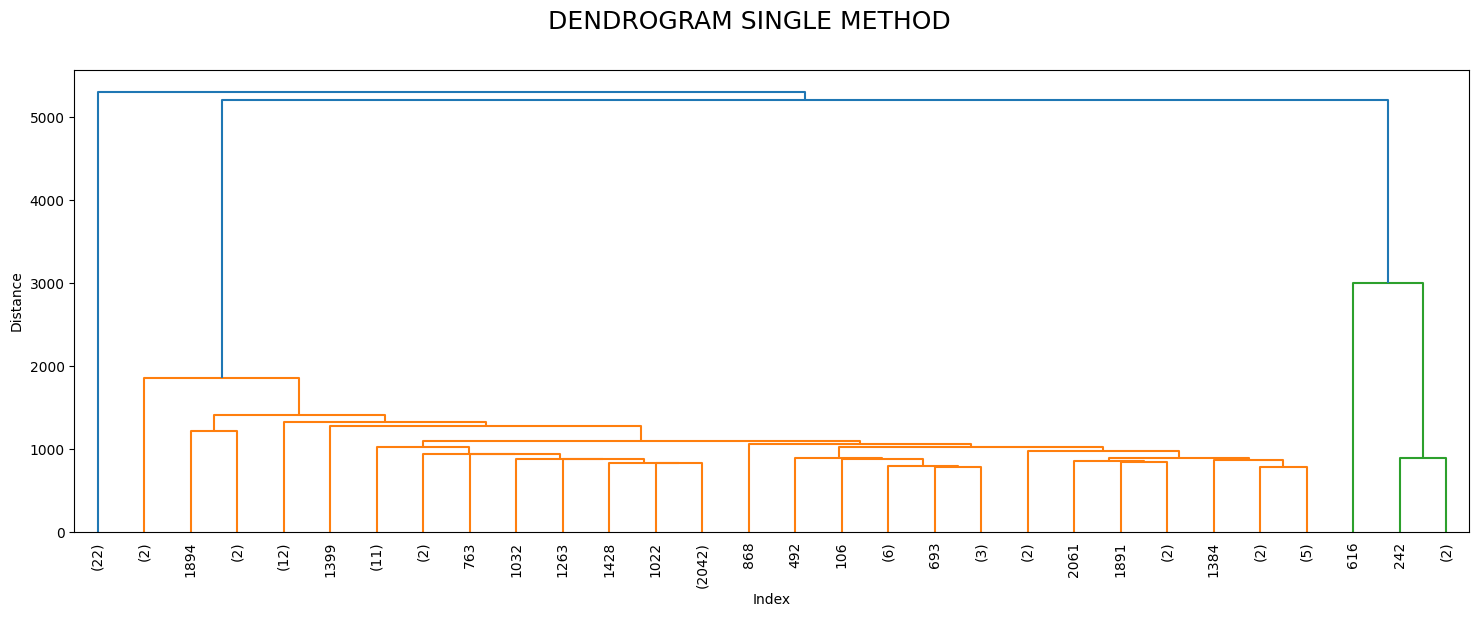

In [ ]:
dist_sin = linkage(X_kmean, method="single")
plt.figure(figsize=(18,6))
dendrogram(dist_sin, leaf_rotation=90, truncate_mode='lastp')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.suptitle("DENDROGRAM SINGLE METHOD",fontsize=18)
plt.show()

In [ ]:
X_kmean.loc[:, '2_clust'] = fcluster(dist_sin, 2, criterion='maxclust')
X_kmean.loc[:, '3_clust'] = fcluster(dist_sin, 3, criterion='maxclust')
X_kmean.loc[:, '4_clust'] = fcluster(dist_sin, 4, criterion='maxclust')

<ipython-input-45-10d136aa0b26>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



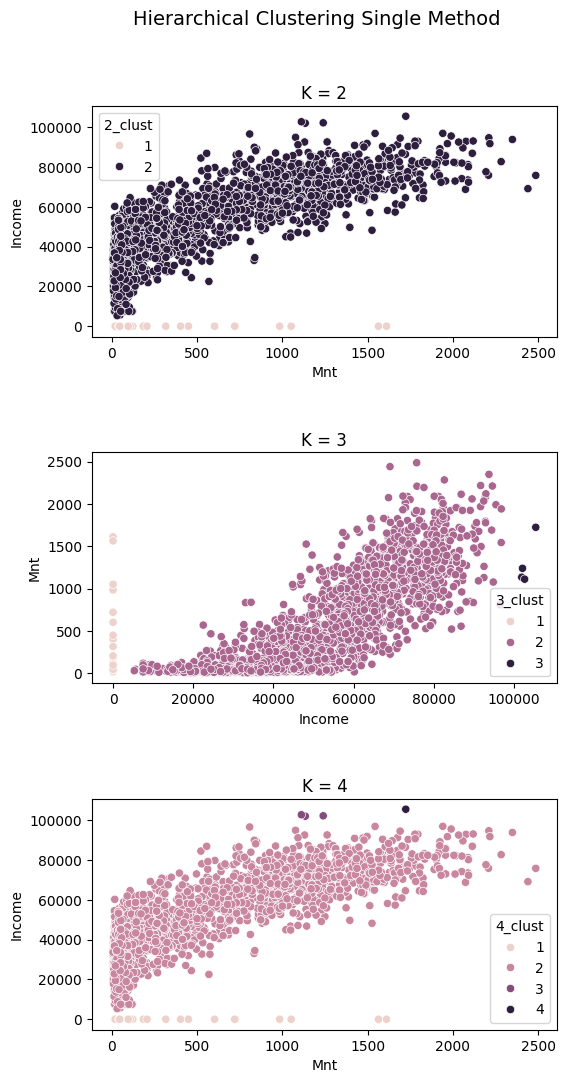

In [ ]:

plt.figure(figsize=(6, 12))

plt.suptitle("Hierarchical Clustering Single Method", fontsize=14, y=0.96)

plt.subplot(3, 1, 1)
plt.title("K = 2", fontsize=12, pad=5)
sns.scatterplot(x="Mnt", y="Income", data=X_kmean, hue="2_clust")

plt.subplot(3, 1, 2)
plt.title("K = 3", fontsize=12, pad=5)
sns.scatterplot(x="Income", y="Mnt", data=X_kmean, hue="3_clust")

plt.subplot(3, 1, 3)
plt.title("K = 4", fontsize=12, pad=5)
sns.scatterplot(x="Mnt", y="Income", data=X_kmean, hue="4_clust")

plt.subplots_adjust(hspace=0.5)

plt.show()



In [ ]:
#Рахуємо метрику силуету для  кластеризації на 2 кластера
# Отримуємо мітки кластерів
labels_n2 = fcluster(dist_sin, t=2, criterion='maxclust')

# Обчислюємо центроїди кластерів
centroids = np.array([X_kmean[labels_n2 == i].mean(axis=0) for i in np.unique(labels_n2)])

# Розраховуємо метрику силуету
s = metrics.silhouette_score(X_kmean, labels_n2, metric='euclidean')
print(f'Silhouette Coefficient for the data Dataset Clusters: {s:.2f}')

Silhouette Coefficient for the data Dataset Clusters: 0.46


In [ ]:
#Рахуємо метрику силуету для  кластеризації на 3 кластера
# Отримуємо мітки кластерів
labels_n3 = fcluster(dist_sin, t=3, criterion='maxclust')

# Обчислюємо центроїди кластерів
centroids = np.array([X_kmean[labels_n3 == i].mean(axis=0) for i in np.unique(labels_n3)])

# Розраховуємо метрику силуету
s = metrics.silhouette_score(X_kmean, labels_n3, metric='euclidean')
print(f'Silhouette Coefficient for the data Dataset Clusters: {s:.2f}')

Silhouette Coefficient for the data Dataset Clusters: 0.27


In [ ]:
#Рахуємо метрику силуету для цієї кластеризації на 4 кластера
# Отримуємо мітки кластерів
labels_n = fcluster(dist_sin, t=4, criterion='maxclust')

# Обчислюємо центроїди кластерів
centroids = np.array([X_kmean[labels_n == i].mean(axis=0) for i in np.unique(labels_n)])

# Розраховуємо метрику силуету
s = metrics.silhouette_score(X_kmean, labels_n, metric='euclidean')
print(f'Silhouette Coefficient for the data Dataset Clusters: {s:.2f}')

Silhouette Coefficient for the data Dataset Clusters: 0.27


**Висновки:** 2 кластери на немасштабованих даних показали кращий результат. Даний метод кластеризації на 2 кластери показав гірші результати (0.46), аніж Kmeans (0.60).

#Додаткові методи кластеризації

В даному розділі буде:
1. Використано метод ієрархічна кластеризація з  способом звʼязності (average);
2. Використано метод кластеризації DBSCAN
3. Використано метод кластеризації K-Medians

## Ієрархічна кластеризація (average)

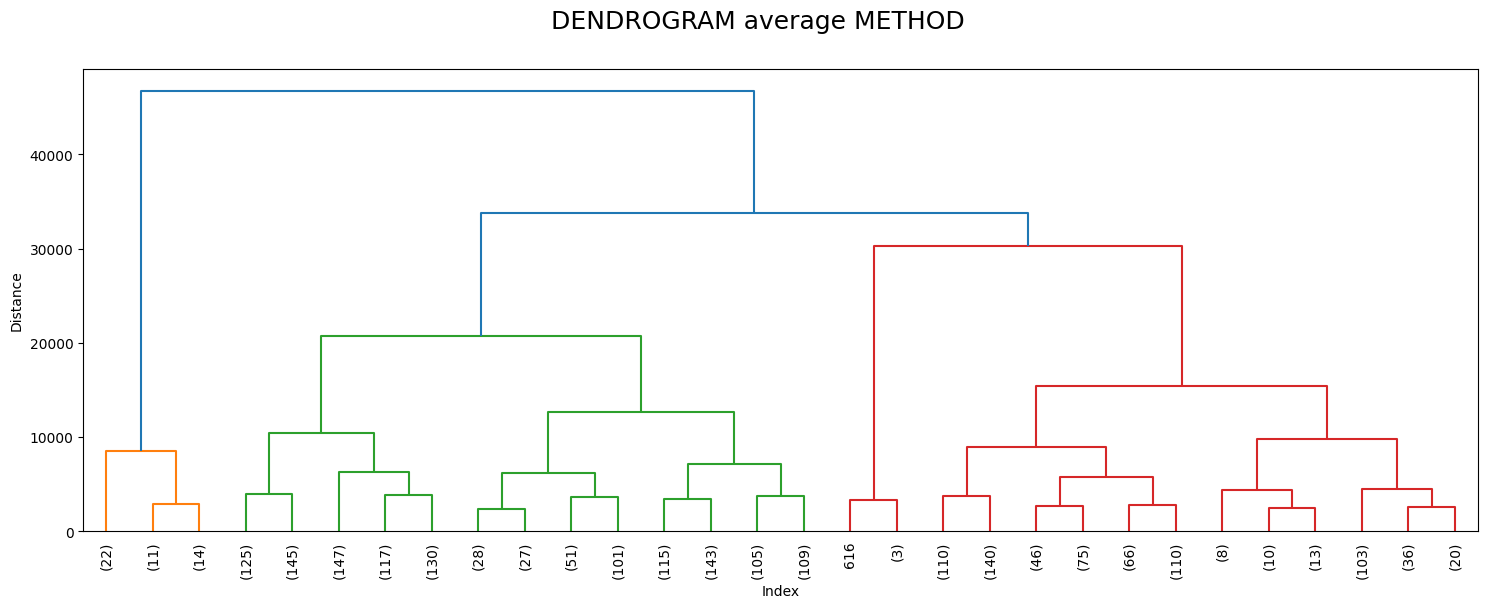

<ipython-input-48-d8b48fab5d82>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-48-d8b48fab5d82>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-48-d8b48fab5d82>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: title={'center': 'K = 4'}, xlabel='Mnt', ylabel='Income'>

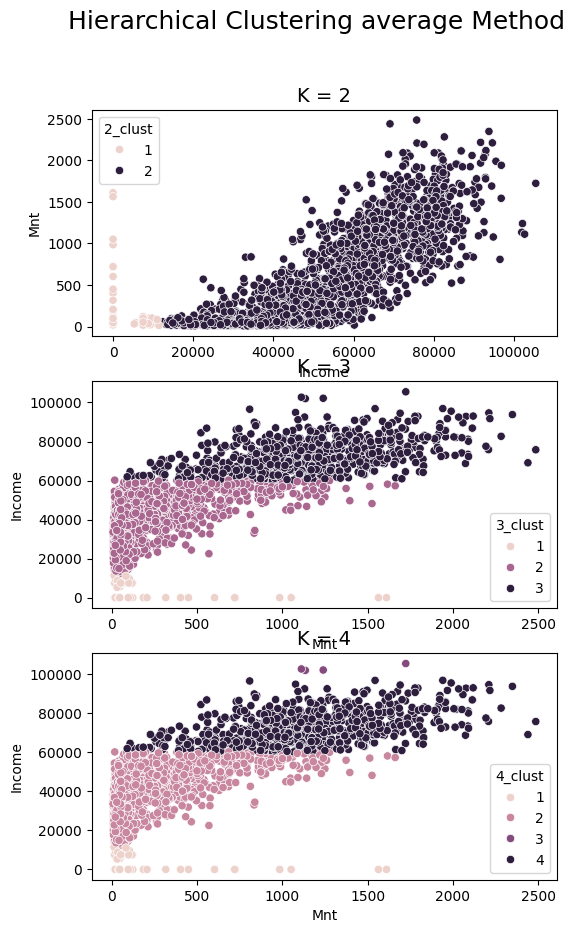

In [ ]:
dist_com = linkage(X_kmean, method="average")
plt.figure(figsize=(18,6))
dendrogram(dist_com, leaf_rotation=90, truncate_mode='lastp')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.suptitle("DENDROGRAM average METHOD",fontsize=18)
plt.show()

X_kmean['2_clust'] = fcluster(dist_com, 2, criterion='maxclust')
X_kmean['3_clust'] = fcluster(dist_com, 3, criterion='maxclust')
X_kmean['4_clust'] = fcluster(dist_com, 4, criterion='maxclust')



plt.figure(figsize=(6,10))

plt.suptitle("Hierarchical Clustering average Method",fontsize=18)

plt.subplot(3,1,1)
plt.title("K = 2",fontsize=14)
sns.scatterplot(x="Income",y="Mnt", data=X_kmean, hue="2_clust")

plt.subplot(3,1,2)
plt.title("K = 3",fontsize=14)
sns.scatterplot(x="Mnt",y="Income", data=X_kmean, hue="3_clust")

plt.subplot(3,1,3)
plt.title("K = 4",fontsize=14)
sns.scatterplot(x="Mnt",y="Income", data=X_kmean, hue="4_clust")

In [ ]:
#Рахуємо метрику силуету для цієї кластеризації на 2 кластери
# Отримуємо мітки кластерів
labels_com2 = fcluster(dist_com, t=2, criterion='maxclust')

# Обчислюємо центроїди кластерів
centroids = np.array([X_kmean[labels_com2 == i].mean(axis=0) for i in np.unique(labels_com2)])

# Розраховуємо метрику силуету
s = metrics.silhouette_score(X_kmean, labels_com2, metric='euclidean')
print(f'Silhouette Coefficient for the data Dataset 2 Clusters: {s:.2f}')

Silhouette Coefficient for the data Dataset 2 Clusters: 0.43


In [ ]:
#Рахуємо метрику силуету для цієї кластеризації на 3 кластери
# Отримуємо мітки кластерів
labels_com = fcluster(dist_com, t=3, criterion='maxclust')

# Обчислюємо центроїди кластерів
centroids = np.array([X_kmean[labels_com == i].mean(axis=0) for i in np.unique(labels_com)])

# Розраховуємо метрику силуету
s = metrics.silhouette_score(X_kmean, labels_com, metric='euclidean')
print(f'Silhouette Coefficient for the data Dataset 3 Clusters: {s:.2f}')

Silhouette Coefficient for the data Dataset 3 Clusters: 0.47


In [ ]:
#Рахуємо метрику силуету для цієї кластеризації на 4 кластери
# Отримуємо мітки кластерів
labels_com_4 = fcluster(dist_com, t=4, criterion='maxclust')

# Обчислюємо центроїди кластерів
centroids = np.array([X_kmean[labels_com_4 == i].mean(axis=0) for i in np.unique(labels_com_4)])

# Розраховуємо метрику силуету
s = metrics.silhouette_score(X_kmean, labels_com_4, metric='euclidean')
print(f'Silhouette Coefficient for the data Dataset 4 Clusters: {s:.2f}')

Silhouette Coefficient for the data Dataset 4 Clusters: 0.43


При ієрархічній кластеризації (average) при трьох кластерах становить 0.47.

##DBSCAN

In [ ]:
dbscan = DBSCAN(eps=0.9, min_samples= 4)
dbscan.fit(X_kmean_dc)
labels_dbs = dbscan.labels_
n_clusters_ = len(set(labels_dbs)) - (1 if -1 in labels_dbs else 0)
n_noise_ = list(labels_dbs).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

s = metrics.silhouette_score(X_kmean_dc, dbscan.labels_)
print(f'Silhouette Coefficient for the data Dataset Clusters: {s:.2f}')


Estimated number of clusters: 2
Estimated number of noise points: 2123
Silhouette Coefficient for the data Dataset Clusters: -0.19


**Висновки:** Дана модель показала погані результати з кластеризації заданого набору даних. На масштабованих даних - найкращі результати і це -0.19

##K-Medians

In [ ]:
pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.5 MB/s eta 0:00:00


In [ ]:
kmedoids = KMedoids(n_clusters=2, metric='euclidean', random_state=0)
kmedoids.fit(X_kmean)

# Get the cluster labels
labels_med_2 = kmedoids.labels_
#Рахуємо метрику силуету для цієї кластеризації
centroids = kmedoids.cluster_centers_
s = metrics.silhouette_score(X_kmean, labels_med_2, metric='euclidean')
print(f'Silhouette Coefficient for the data Dataset Clusters: {s:.2f}')

Silhouette Coefficient for the data Dataset Clusters: 0.60


In [ ]:
kmedoids = KMedoids(n_clusters=3, metric='euclidean', random_state=0)
kmedoids.fit(X_kmean)

# Get the cluster labels
labels_med_3 = kmedoids.labels_
#Рахуємо метрику силуету для цієї кластеризації
centroids = kmedoids.cluster_centers_
s = metrics.silhouette_score(X_kmean, labels_med_3, metric='euclidean')
print(f'Silhouette Coefficient for the data Dataset Clusters: {s:.2f}')

Silhouette Coefficient for the data Dataset Clusters: 0.54


In [ ]:
# Візуалізація
fig = px.scatter_3d(X_kmean, x='Mnt', y='Income', z='Age_client',
              color= labels_med_2)
fig.show()

Найкращий результат показала кластеризація за допомогою K-means nf K-medoids на 2 кластери (0.60).
На 3 кластери дані моделі поділили дані з метрикою 0.54

Для подальших аналізів портретів клієнтів буду використовувати метод K-means на 3 кластери.

# Зменшення розмірності (PCA) для інтерпритації портрету клієнта

Для пониження розмірності будемо використовувати масштабовані дані. Вони у нас масштабовані StandardScaler.

In [ ]:
#Вибір ключових характеристик
colum = ['Income', 'Recency', 'NumStorePurchases', 'NumDealsPurchases', 'Days_lifetime', 'Age_client', 'NumWebVisitsMonth']
X = X_kmean[colum]

In [ ]:
#Нормалізація даних
scaler = MinMaxScaler()
scaler.fit(X)
X_sc = scaler.transform(X)
# Перетворення назад у DataFrame
X_sc = pd.DataFrame(X_sc, columns=X.columns)

In [ ]:
#кластеризація Kmeans масштабоване
kmeans_sc = KMeans(n_clusters=3, n_init='auto')
kmeans_sc.fit(X_sc)
labels_sc = kmeans_sc.predict(X_sc)

#Рахуємо метрику силуету для цієї кластеризації
centroids = kmeans_sc.cluster_centers_
s = metrics.silhouette_score(X_sc, labels_sc, metric='euclidean')
print(f'Силует коефіцієнт для масштабованих даних: {s:.2f}')

Силует коефіцієнт для масштабованих даних: 0.19


In [ ]:
#Пониження розмірності масштабоване
pca2 = PCA(n_components=3)
X_pca2 = pca2.fit_transform(X_sc)

In [ ]:
#Візуалізація кластеризації масштабованих даних
fig = px.scatter_3d(x=X_pca2[:, 0], y=X_pca2[:, 1], z=X_pca2[:, 2],
                     color=labels_sc)
fig.show()

**Висновки:** На візуалізації видно, що дані скупчені і немає візуальних відстаней між кластерами. В той же час далі від межі перетину відсутні змішування кластерів.

##Аналіз результатів пониження розмірності

В цьому розділі буде:
1. Розрахунок частки поясненої дисперсії за допомогою атрибуту `explained_variance_ratio_` об'єкта PCA;
2. Розрахунок кумулятивної частки поясненої дисперсії для трьох головних компонент, щоб зрозуміти, скільки варіації даних пояснюється першими кількома компонентами.

In [ ]:
#Розрахунок частки поясненої дисперсії
print('Частки поясненої дисперсії:', pca2.explained_variance_ratio_)

#Розрахунок кумулятивної частки поясненої дисперсії
print('Кумулятивна частка поясненої дисперсії:', np.sum(pca2.explained_variance_ratio_))

Частки поясненої дисперсії: [0.27777287 0.25531889 0.24713   ]
Кумулятивна частка поясненої дисперсії: 0.7802217539650359


 ## Інтерпретація "Loadings"

В даному розділі буде:
1.  Обчислено "навантаження" для кожної з головних компонент;
2. Проведено інтерпретація результатів.

In [ ]:
# Обчислення loadings для компонент
components_df2 = pd.DataFrame(data=pca2.components_, columns=X_sc.columns, index=[f'PC{i+1}' for i in range(pca2.n_components_)])

In [ ]:
#Інтерпретація результатів
components_df2

,Income,Recency,NumStorePurchases,NumDealsPurchases,Days_lifetime,Age_client,NumWebVisitsMonth
PC1,0.504258,0.118959,0.742598,0.046539,0.330212,0.200432,-0.169533
PC2,-0.220229,0.674604,-0.192153,0.080170,0.648002,-0.083923,0.161583
PC3,0.115345,0.728009,0.047289,-0.092338,-0.648629,0.073519,-0.140756


**Висновки:**

1. **PC1** Найбільше впливають наступні ознаки:
   - NumStorePurchases (кількість покупок) - 0.74;
   - Days_lifetime (Час на платформі) - 0.33;
   - Income (дохід) - 0.50

2. **PC2** Найбільше впливають наступні ознаки:
   - Recency (кількість днів з останьої полкупки) - 0.67;
   - Days_lifetime (час на платформі) - 0.64;
   - Income (дохід) -  -0.22

3. **PC3** Найбільше впливають наступні ознаки:
   - Recency (кількість днів з останньої покупки) - 0.72;
   - Days_lifetime (час на платформі) - 0.64.

# Зменшення розмірності (t-SNE ) для інтерпритації портрету клієнта

In [ ]:
#t-SNE для зниження розмірності до 2х вимірів даних
tsne = TSNE(n_components=2, random_state=0)
tsne_X = tsne.fit_transform(X_sc)

In [ ]:
# Створюємо DataFrame з t-SNE координатами
df_tsne = pd.DataFrame(tsne_X, columns=['Component 1', 'Component 2'])

# Додаємо мітки кластерів
df_tsne['Cluster'] = labels_sc

In [ ]:
#Візуалізація
fig = px.scatter(df_tsne, x='Component 1', y='Component 2', color="Cluster")
fig.show()

**Інтерпритація кластеризації візуалізованої через t-sne**

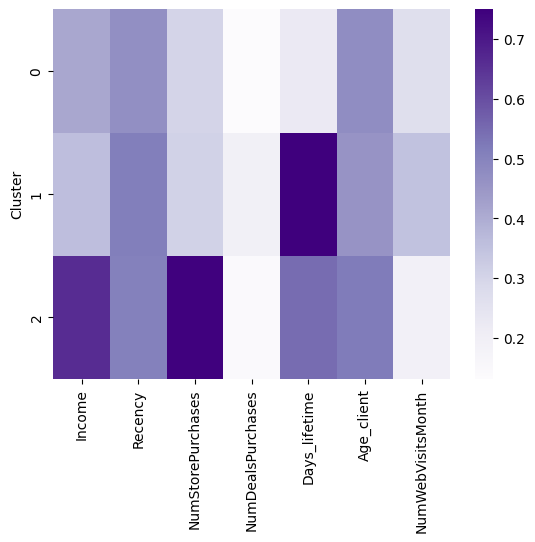

In [ ]:
# Припустимо, у вас є DataFrame df з даними і мітками кластерів labels
X_sc['Cluster'] = labels_sc  # Додаємо мітки кластерів до DataFrame

# Обчислюємо середні значення для кожного кластеру
cluster_means = X_sc.groupby('Cluster').mean()
sns.heatmap(cluster_means, cmap="Purples");

In [ ]:
# Додаємо колонки
df_tsne['Income'] = X_sc['Income']
df_tsne['NumStorePurchases'] = X_sc['NumStorePurchases']
df_tsne['Days_lifetime'] = X_sc['Days_lifetime']
df_tsne['NumWebVisitsMonth'] = X_sc['NumWebVisitsMonth']
df_tsne['Age_client'] = X_sc['Age_client']


In [ ]:
#Візуалізація
color_sequence = ['green', 'orange', 'purple']
fig = px.scatter(df_tsne, x='Component 1', y='Component 2', color="Cluster",
                 size='NumStorePurchases', hover_data=['Days_lifetime'])

fig.show()

**Інтерпритація кластеризації даних:**
Кластери не є чітко вираженими графічно.

Кластер 0 (синій):. Його ознаками є:
- низький рівень покупок в фізичних магазинах;
- недавно на платформі;
- середній дохід серед клієнтів

Кластер 1 (червоний). Його ознаками є:
- давно на платформі;
- покупки в фізичних магазинах нижче середнього
- річний дохід нижче середнього

Кластер 2 (жовтий). його ознаками є:
- дуже рідко останній місяць відвідували сайт
- мають високий річний дохід;
-  часто купували в фізичному магазині

#Висновки
В даному ноутбуці було проведено підбір моделі для кластеризації даних про клієнтів. На основі обраної моделі було проведено зменшення розмірності та виявлено характеристики які впливають на такі кластери, та проінтерпретовано вплив характеритсик та їх поєднання на клієнтів в такому кластері.